# Mazouz Abderahim, LAB4 , Master 1


---
---




# Pre-processing Data





In [8]:
import re
import json

In [9]:
# Read the Jason file all the content

def readfile(path):
  with open(path,"r") as file:
    return file.readlines()

In [10]:
'''
  Source_to_ref is function that returns a Dict
    - keys are the source sentence in English
    - values are the target language in French
'''

def source_to_ref(content):
  src_to_ref = {}
  for line in lines:
    data = json.loads(line)
    for key,value in data.items():
      if key == "reference":
        ref = data[key]
      if key=="source":
        src =data[key]
    src_to_ref[src]=ref
  return src_to_ref

In [11]:
lines = readfile("/content/sample_data/Challenge_set-v2hA.json")

src_to_ref = source_to_ref(lines)


## Which translation model is used when using an HuggingFace translation pipeline ?
## by default the google-t5/t5-base model is used


In [50]:
from transformers import pipeline

In [ ]:
translator = pipeline("translation_en_to_fr")

In [73]:
import time

start_time = time.time() # To calculate the time execution


predictions = []
references = []

for reference in src_to_ref.values():

  references.append(reference)
  predicted_text = translator(reference)
  predictions.append(predicted_text[0]['translation_text'])


print("\n--- %s seconds ---" % (time.time() - start_time))


--- 279.65117359161377 seconds ---


In [81]:
for i in range(4):
  print("refrence sentence:  ",references[i])
  print("predicted sentence: ",predictions[i])

refrence sentence:   Les appels répétés de sa mère [auraient] dû nous alerter.
predicted sentence:  Les appels répétés de sa mère [auraient] dû nous alerter.
refrence sentence:   Le bruit soudain dans les chambres supérieures [aurait] dû nous alerter.
predicted sentence:  Le bruit dans les chambres supérieures aurait dû nous alerter.
refrence sentence:   Leurs échecs répétés à signaler le problème [auraient] dû nous alerter.
predicted sentence:  Les échecs répétés à signaler le problème [auraient] dû nous alerter.
refrence sentence:   Elle a demandé à son frère de ne pas se montrer [arrogant].
predicted sentence:  Elle a demandé à son frère de ne pas se montrer [arrogant].


### THE Blue Score when using HuggingFace translation pipeline:

In [ ]:
!pip install sacrebleu

In [53]:
import evaluate

sacrebleu = evaluate.load("sacrebleu")
results = sacrebleu.compute(predictions=predictions, references=references)

print(f"The Blue Score ==> {results['score']}")

The Blue Score ==> 95.0735179697016


# Mistral LLM:

## Loading the Model

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline
import torch

In [ ]:
!pip install accelerate

In [ ]:
model_name = "mistralai/Mistral-7B-v0.1"


model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=torch.float16,
                                             device_map="cuda",
                                             low_cpu_mem_usage=True
                                            )

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [5]:
pipe = pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    torch_dtype = torch.bfloat16,
    )

In [6]:
import re

'''
  get_translation is a function that it is used to extract the translated sentence from
  the generated text by LLM
'''
def get_translation(text):

  pattern = r'"([^"]*)"'
  matches = re.findall(pattern, text)

  prediction = matches[3]


  return prediction

 ## Translating 108 sentence

In [12]:
import time

start_time = time.time() # To calculate the time execution

# English and French texts are used for the few shot
English_text = "I'am student"
French_translation = "je suis etudiant"

predictions = []
references = []


for source,reference in src_to_ref.items():

  references.append(reference)

  prompt = f''' English 1: "{English_text}": French 1: "{French_translation}"; English 2: "{source}": French 2: '''
  translated_text = pipe(prompt,max_new_tokens=50)

  prediction = get_translation(translated_text[0]["generated_text"])
  predictions.append(prediction)

time = (time.time() - start_time)

print(f"\n--- {time} seconds ---")




Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token


--- 357.51153540611267 seconds ---


In [13]:
print(f"Execution time of 108 sentence : --- {time} ---")

Execution time of 108 sentence : --- 357.51153540611267 ---


In [79]:
for i in range(4):
  print("refrence sentence:  ",references[i])
  print("predicted sentence: ",predictions[i])

refrence sentence:   Les appels répétés de sa mère [auraient] dû nous alerter.
predicted sentence:  Les appels répétés de sa mère [auraient] dû nous alerter.
refrence sentence:   Le bruit soudain dans les chambres supérieures [aurait] dû nous alerter.
predicted sentence:  Le bruit dans les chambres supérieures aurait dû nous alerter.
refrence sentence:   Leurs échecs répétés à signaler le problème [auraient] dû nous alerter.
predicted sentence:  Les échecs répétés à signaler le problème [auraient] dû nous alerter.
refrence sentence:   Elle a demandé à son frère de ne pas se montrer [arrogant].
predicted sentence:  Elle a demandé à son frère de ne pas se montrer [arrogant].


## The score of mistralai/Mistral-7B-v0.1 model

In [49]:
results = sacrebleu.compute(predictions=predictions, references=references)

print(f"The Blue Score ==> {results['score']}")

The Blue Score ==> 25.40877657338304


# Visualation and conclusion

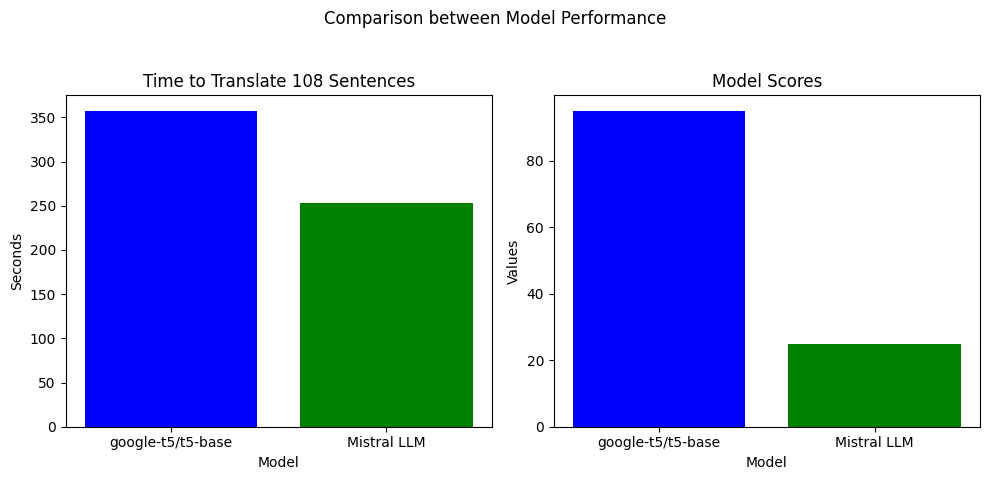

In [14]:
import matplotlib.pyplot as plt

# Data for time taken to translate 108 sentences
time = [357, 253]
time_labels = ['google-t5/t5-base', 'Mistral LLM']

# Data for model scores
scores = [95, 25]
score_labels = ['google-t5/t5-base', 'Mistral LLM']

# Plot for time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Subplot 1
plt.bar(time_labels, time, color=['blue', 'green'])
plt.title('Time to Translate 108 Sentences')
plt.xlabel('Model')
plt.ylabel('Seconds')

# Plot for scores
plt.subplot(1, 2, 2)  # Subplot 2
plt.bar(score_labels, scores, color=['blue', 'green'])
plt.title('Model Scores')
plt.xlabel('Model')
plt.ylabel('Values')

# Add a conclusion
plt.suptitle('Comparison between Model Performance')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()


After comparing the performance of the 'google-t5/t5-base' and 'Mistral LLM' models, several observations can be made:


*   The 'google-t5/t5-base' model received a higher score and faster compared to the 'Mistral LLM' model


